# 调参

## GridSearchCV()

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
import pandas as pd

from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target
feature = iris.feature_names
data = pd.DataFrame(X,columns=feature)
data['target'] = y
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [12]:
# 使用网格搜索进行超参数调优：
# 方式1：网格搜索GridSearchCV()
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline # 引入管道简化学习流程
from sklearn.preprocessing import StandardScaler # 由于SVR基于距离计算，引入对数据进行标准化的类
from sklearn.svm import SVC # 引入support Vector Classification
from sklearn.model_selection import GridSearchCV  # 引入网格搜索调优

import time

start_time = time.time()
# make_pipeline with standard scale and SVC
pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=1))
# set parameters
param_range = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
# set grid
param_grid = [{'svc__C':param_range,'svc__kernel':['linear']},
              {'svc__C':param_range,'svc__gamma':param_range,'svc__kernel':['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X,y)
end_time = time.time()
print("网格搜索经历时间：%.3f S" % float(end_time-start_time))
print(gs.best_score_)
print(gs.best_params_)

网格搜索经历时间：3.765 S
0.98
{'svc__C': 1.0, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}


## RandomizedSearchCV()

In [24]:
# 方式2：随机网格搜索RandomizedSearchCV()
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform  # 引入均匀分布设置参数
from sklearn import linear_model 
import time

start_time = time.time()

# Create logistic regression
logistic = linear_model.LogisticRegression()

param_range = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)


gs = RandomizedSearchCV(estimator=logistic, 
                        param_distributions=hyperparameters,
                        scoring='accuracy',
                        cv=10,
                        n_jobs=-1)
gs = gs.fit(X,y)
end_time = time.time()
print("随机网格搜索经历时间：%.3f S" % float(end_time-start_time))
print(gs.best_score_)
print(gs.best_params_)

随机网格搜索经历时间：3.134 S
0.9666666666666667
{'C': 3.5993735360766115, 'penalty': 'l1'}


# Confusion Matrix

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use("ggplot") 

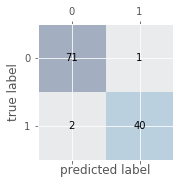

In [28]:
df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data",header=None)
'''
乳腺癌数据集：569个恶性和良性肿瘤细胞的样本，M为恶性，B为良性
'''
# 做基本的数据预处理
from sklearn.preprocessing import LabelEncoder

X = df.iloc[:,2:].values
y = df.iloc[:,1].values

#mEncode target labels with value between 0 and n_classes-1.
le = LabelEncoder() 
# fit labelencoder and return the encoded labels (0-1-2-...)
y = le.fit_transform(y) 
# transform labels to normalized encoding['M','B']
le.transform(['M','B'])


# 数据切分8：2
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=1)

from sklearn.svm import SVC
pipe_svc = make_pipeline(StandardScaler(),SVC(random_state=1))

from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train,y_train)
y_pred = pipe_svc.predict(X_test)

confmat = confusion_matrix(y_true=y_test,y_pred=y_pred)
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat, cmap=plt.cm.Blues,alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,y=i,s=confmat[i,j],va='center',ha='center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

# ROC

<Figure size 432x288 with 0 Axes>

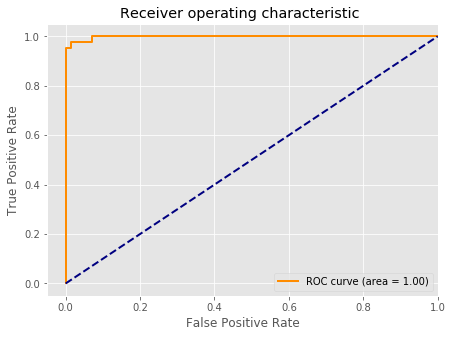

In [29]:
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import make_scorer,f1_score

# make a scorer from a performance metric or loss function
scorer = make_scorer(f1_score,pos_label=0)

# GridSearchCV
gs = GridSearchCV(estimator=pipe_svc,param_grid=param_grid,scoring=scorer,cv=10)
# call decision_function on the estimator with the best found parameters
y_pred = gs.fit(X_train,y_train).decision_function(X_test)
#y_pred = gs.predict(X_test)

fpr,tpr,threshold = roc_curve(y_test, y_pred) ###计算真阳率和假阳率
roc_auc = auc(fpr,tpr) ###计算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假阳率为横坐标，真阳率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ')
plt.legend(loc="lower right")
plt.show()

# sklearn dataset

Labeled Faces in the Wild (LFW) people dataset

In [36]:
from sklearn.datasets import fetch_lfw_people
lfw=fetch_lfw_people(min_faces_per_person=100, resize=0.4)
# specify at least min_faces_per_person number of different pictures

In [49]:
n_samples, h, w = lfw.images.shape

X = lfw.data
n_features = X.shape[1]

y = lfw.target
target_names = lfw.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1140
n_features: 1850
n_classes: 5


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)